In [106]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from hypopt import GridSearch

In [24]:
def read_data(filename, data_dir='data'):
    df = pd.read_csv(os.path.join(data_dir, filename), index_col=0)
    df.fillna('?', inplace=True)
    return df

df_train = read_data('diab_train_filtered.csv')
df_val = read_data('diab_validation_filtered.csv')
df_test = read_data('diab_test_filtered.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 9011 to 1625
Data columns (total 21 columns):
race                        6000 non-null object
gender                      6000 non-null object
age                         6000 non-null object
admission_type_id           6000 non-null object
discharge_disposition_id    6000 non-null object
admission_source_id         6000 non-null object
time_in_hospital            6000 non-null int64
num_lab_procedures          6000 non-null int64
num_procedures              6000 non-null int64
num_medications             6000 non-null int64
number_outpatient           6000 non-null int64
number_emergency            6000 non-null int64
number_inpatient            6000 non-null int64
diag_1                      6000 non-null int64
number_diagnoses            6000 non-null int64
max_glu_serum               6000 non-null object
A1Cresult                   6000 non-null object
change                      6000 non-null object
diabetesMed      

In [93]:
df_train.age.value_counts()

[70-80)      1550
[60-70)      1330
[80-100)]    1129
[50-60)      1024
[0-50)        967
Name: age, dtype: int64

### Prepare data
Replace categorical variables by one-hot encodings, ignore text for now

In [94]:
def prepare_data(df, scaler, categorical_vars, numerical_vars):
    categoricals = df.loc[:, categorical_vars]
    ## rename values with >, [, ] for xgboost
    categoricals.max_glu_serum = categoricals.max_glu_serum.replace({'>200': 'greater_200', '>300': 'greater_300'})
    categoricals.A1Cresult = categoricals.A1Cresult.replace({'>8': 'greater_8', '>7': 'greater_7'})
    categoricals.age = categoricals.age.str.replace('[', '(')
    categoricals.age = categoricals.age.str.replace(']', ')')
    categoricals = pd.get_dummies(categoricals)
    y = df.readmitted
    x = df.drop(columns=['readmitted', 'diag_1_desc'] + categorical_vars)
    x[numerical_vars] = scaler.transform(x[numerical_vars])
    x = x.join(categoricals)
    
    return x, y

In [95]:
categorical_vars = ['race', 'age', 'gender', 'diag_1', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', \
                    'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed']
numerical_vars = df_train.columns[6:13].tolist() + [df_train.columns[14]]

scaler = StandardScaler()
scaler.fit(df_train[numerical_vars])

X_train, Y_train = prepare_data(df_train, scaler, categorical_vars, numerical_vars)
X_val, Y_val = prepare_data(df_val, scaler, categorical_vars, numerical_vars)
X_test, Y_test = prepare_data(df_test, scaler, categorical_vars, numerical_vars)

In [86]:
X_train.shape, X_test.shape, X_val.shape

((6000, 41), (2000, 41), (2000, 41))

## Feature Importance
We train a Random Forest Classifier and extract the feature importances. This is plotted in the graph below.

We find that the number of lab procedures, number of medications, time in hospital, number of diagnostics and number of procedures and number inpatients seem to be the most relevant features. These features make intuitive sense. Patients that had to undertake more lab procedures, took more medication and spent more time in the hospital most likely had more aggravated prognostics. Simarly, patients that had to undertake many procedures and visited the hospital many times were likely in worse health.

By training models that start by using only the most important feature, and successively add the next most important one, and plotting their validation and train accuracy, we see that using these less important features leads the model to aggressively overfitting.

0.6365


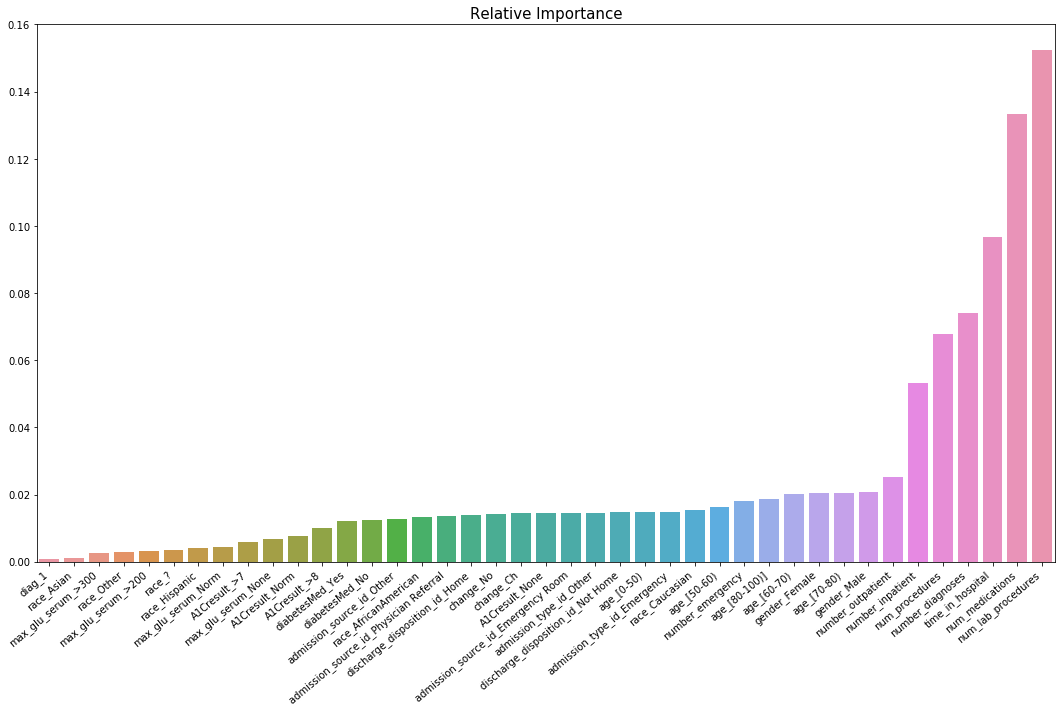

In [32]:
clf = RandomForestClassifier()
clf.fit(X_train, Y_train)
print(clf.score(X_val, Y_val))
importances = clf.feature_importances_

relative = 100 * (importances / importances.max())
indices = np.argsort(importances)
features = X_train.columns.values.tolist()
feature_names_sort = [features[i] for i in indices]

plt.figure(figsize=(15, 10))
plt.title('Relative Importance', fontsize=15)
ax = sns.barplot(x=feature_names_sort, y=importances[indices])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

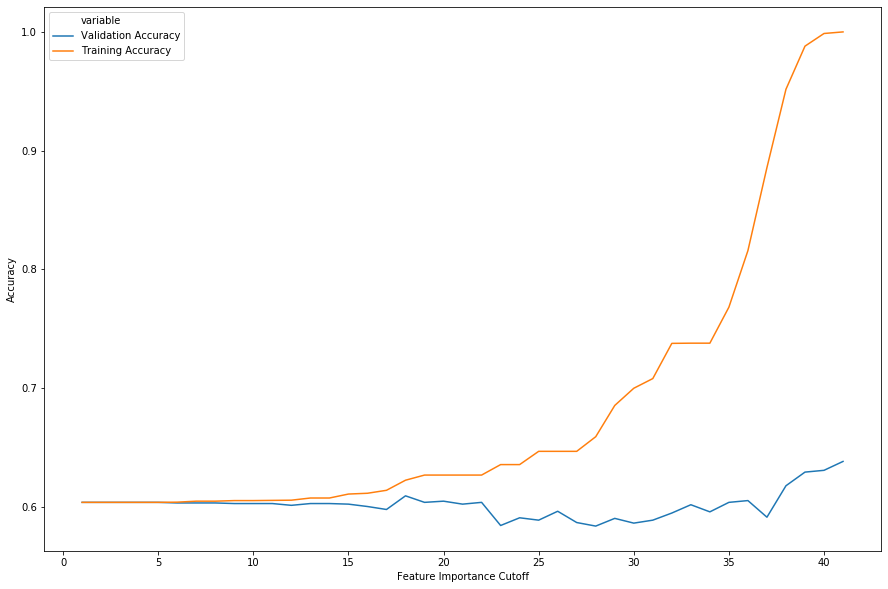

In [33]:
train_acc = []
val_acc = []
cutoff = []
for i in range(1, X_train.columns.shape[0] + 1):
    clf = RandomForestClassifier()
    filtered = X_train.columns[indices[:i]].tolist()
    clf.fit(X_train[filtered], Y_train)
    train_acc.append(clf.score(X_train[filtered], Y_train))
    val_acc.append(clf.score(X_val[filtered], Y_val))
    cutoff.append(i)

data = pd.DataFrame({
    'Feature Importance Cutoff': cutoff,
    'Validation Accuracy': val_acc,
    'Training Accuracy' : train_acc
})
plt.figure(figsize=(15, 10))
sns.lineplot(x='Feature Importance Cutoff', y='Accuracy', hue='variable', 
             data=pd.melt(data, ['Feature Importance Cutoff'], value_name='Accuracy'))

### Model selection:
We choose gradient boosted decision trees as our classifiers. These are very powerful models, and tend to perform well especially in our case, where the dataset is not very large.

We run a gridsearch to determine the best parameters.

In [112]:
params = {'n_estimators': [100, 200, 500, 1000, 2000],
          'max_depth' : [3, 6, 8],
          'reg_alpha': [0, 0.2, 0.4],
          'reg_lambda' : [0.4, 0.7, 1],
          'learning_rate': [0.1, 0.3]}

dummy = {'n_estimators': [100],
          'max_depth' : [6],
          'reg_alpha': [0],
          'reg_lambda' : [1],
          'learning_rate': [0.3]}
opt = GridSearch(param_grid=params, model=XGBClassifier(random_state=42))
opt.fit(X_train, Y_train, X_val, Y_val)
clf = opt.best_estimator_
predictions = clf.predict(X_val)
print("Accuracy : {}".format(accuracy_score(Y_val, predictions)))
print("F1-Score : {}".format(f1_score(Y_val, predictions)))
print(confusion_matrix(Y_val, predictions))

Accuracy : 0.6555
F1-Score : 0.43663123466884707
[[1044  163]
 [ 526  267]]
